# 1. Overview

This competition, "Pump it Up: Data Mining the Water Table," hosted on DrivenData, challenges participants to predict the functional status of water pumps across Tanzania using a provided dataset. The contest spans from 2024 and aims to enhance access to clean, potable water by identifying malfunctioning water pumps. Participants are supplied with extensive data on various characteristics of the water points, from construction year to water quality. The primary goal is to classify each water point into one of three categories: functional, functional needs repair, and non-functional. This analysis could guide strategic decisions for improving water access and infrastructure investments in developing regions.

# 2. Business Understanding

The core objective of the "Pump it Up: Data Mining the Water Table" competition is to enable the identification of water pumps in Tanzania that are functional, require repairs, or are non-functional. The insights derived from this analysis will directly influence decisions regarding maintenance, investments, and resource allocation in the water infrastructure sector. Stakeholders, including government agencies and NGOs, will use these findings to prioritize and streamline efforts towards ensuring reliable water access. By effectively categorizing water points, the project aims to enhance operational efficiencies and reduce downtime due to pump failures. The ultimate goal is to support sustainable water management practices that can significantly impact public health and economic development in Tanzania.

Primary stakeholders for this project are the Tanzanian government and international development organizations focused on improving water access in the region.

# 3. Data Understanding

## 3.1 Data Description

Drawing from a comprehensive dataset provided by the "Pump it Up: Data Mining the Water Table" competition on DrivenData, our analysis is centered around extensive information regarding water points across Tanzania. This dataset includes:

- Geographic data such as location coordinates, altitude, and administrative divisions (region, district, and ward).
- Water point specifics such as the type, construction year, funding organization, and managing entity.
- Operational data including the water source, extraction type, water quality, and current functional status of each water pump.

Our investigation targets three key objectives: identifying patterns of pump functionality, understanding factors leading to pump failures or repairs, and assessing the impacts of management practices on pump operability. By analyzing these elements, we aim to derive actionable insights that can guide infrastructural improvements and strategic investments in water resource management. The outcome of this analysis will inform decision-making processes for stakeholders involved in Tanzanian water supply, optimizing interventions for enhanced water accessibility and reliability. This focused approach empowers our stakeholders to efficiently address the most critical needs, leveraging data-driven strategies to improve public health and community resilience.

## 3.2 Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re  # Import regular expressions library

from IPython.display import display

## 3.3 Define global variables

In [2]:
INPUT_PATH_Submission_Format = "../Data/SubmissionFormat.csv"
INPUT_PATH_Test_set_values = "../Data/Test_set_values.csv"
INPUT_PATH_Training_set_labels = "../Data/Training_set_labels.csv"
INPUT_PATH_Training_set_values = "../Data/Training_set_values.csv"

## 3.4 Functions

In [3]:
def categorize_funder(funder):
    """
    Categorizes a funder name into specific groups based on keywords.
    
    Args:
    funder (str): A string representing the name of the funder to categorize.
    
    Returns:
    str: A category name representing the type of organization the funder belongs to.
    
    This function takes a funder name, converts it to lowercase, removes leading/trailing spaces, 
    and categorizes it into predefined groups like 'Government', 'Religious Organizations', 'NGO',
    'International Aid', 'Private Companies', or 'Individual/Other' based on keywords found within the name.
    """
    funder = funder.lower().strip()  # convert to lowercase and strip whitespaces to standardize
    if any(x in funder for x in ['government','ministry','gov','minis']): 
        return 'Government'
    elif any(x in funder for x in ['church', 'muslim','mus', 'islamic','islam','catholic', 'rc']):
        return 'Religious Organizations'
    elif any(x in funder for x in ['ngo', 'foundation', 'fund', 'trust', 'society','socie']):
        return 'NGO'
    elif any(x in funder for x in ['international','internatio', 'un', 'world bank']):
        return 'International Aid'
    elif any(x in funder for x in ['ltd', 'company','compa', 'group', 'enterprise']):
        return 'Private Companies'
    else:
        return 'Individual/Other'


In [4]:
def categorize_installer(installer):
    """
    Categorizes an installer name into specific groups based on keywords.

    Args:
    installer (str): A string representing the name of the installer to categorize.

    Returns:
    str: A category name representing the type of entity the installer belongs to.

    This function processes an installer name by converting it to lowercase and removing
    any leading/trailing whitespace. It categorizes the name into predefined groups such as 
    'DWE', 'Government', 'Community', 'NGO', 'Private Company', 'Institutional', or 'Other' 
    based on specific keywords present in the installer's name. This helps in standardizing 
    installer data for better analysis and insight extraction.
    """
    installer = installer.lower().strip()  # convert to lowercase and strip whitespaces to standardize
    if 'dw' in installer:
        return 'DWE'
    elif any(x in installer for x in ['government', 'govt', 'gove']):
        return 'Government'
    elif any(x in installer for x in ['resource']):
        return 'Other'
    elif any(x in installer for x in ['community', 'villagers', 'village','commu']):
        return 'Community'
    elif any(x in installer for x in ['ngo', 'unicef', 'foundat']):
        return 'NGO'
    elif 'company' in installer or 'contractor' in installer:
        return 'Private Company'
    elif any(x in installer for x in ['school','schoo','church', 'rc']):
        return 'Institutional'
    else:
        return 'Other'

In [5]:
def group_scheme_management(value):
    """
    Categorizes scheme management types into broader, more generalized groups.

    Args:
    value (str): A string representing the scheme management type to categorize.

    Returns:
    str: A generalized category name representing the type of scheme management.

    This function takes a specific scheme management type and categorizes it into 
    more generalized groups such as 'Government', 'Community', 'Private Sector', 
    'Water Board', or 'Other'. This categorization aids in simplifying the analysis 
    and understanding of the data by reducing the number of distinct categories, 
    making trends and patterns more discernible.
    """
    if value in ['VWC', 'Water authority', 'Parastatal']:
        return 'Government'
    elif value in ['WUG', 'WUA']:
        return 'Community'
    elif value in ['Company', 'Private operator']:
        return 'Private Sector'
    elif value == 'Water Board':
        return 'Water Board'  # Retain this as a separate category if distinct characteristics are important
    else:
        return 'Other'


In [6]:
def clean_text(text):
    """
    Cleans a text string by converting to lowercase, removing non-alphanumeric characters (excluding numbers),
    and replacing multiple spaces with a single space. If the input is solely numeric, it returns the input as is.

    Args:
    text (str or NaN): The text to be cleaned; can be a string, numeric, or NaN for missing values.

    Returns:
    str or NaN: The cleaned text, with all characters in lowercase, non-alphanumeric characters removed (excluding numbers),
                and multiple spaces collapsed to a single space, or the original text if input was numeric or NaN if input was NaN.

    This function standardizes a text string by making it lowercase, stripping out any characters that are not letters or spaces,
    and then replacing sequences of spaces with a single space, facilitating uniform data processing and analysis. If the input
    is numeric, it is assumed to be standardized already and is returned without modification.
    """
    if pd.isna(text):
        return text
    if isinstance(text, (int, float)):  # Check if the input is numeric
        return text
    text = text.lower()  # Convert to lowercase
    text = ''.join(char for char in text if char.isalpha() or char.isspace())  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

In [7]:
def analyze_numeric_stats_and_plots(df, columns):
    """
    Calculates and prints descriptive statistics, and generates boxplots and histograms for specified numeric columns in a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): List of numeric column names to analyze.

    The function computes the mean, median, standard deviation, coefficient of variation, skewness,
    kurtosis, and quartiles for the specified columns. It also generates a boxplot and histogram for each column.
    """
    for column in columns:
        if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
            print(f"Stats for {column}:")
            
            # Calculate statistics
            max_value = df[column].max()
            min_value = df[column].min()
            mean = df[column].mean()
            median = df[column].median()
            std_dev = df[column].std()
            coeff_variation = std_dev / mean if mean != 0 else np.nan
            skewness = df[column].skew()
            kurtosis = df[column].kurtosis()
            quartiles = df[column].quantile([0.25, 0.5, 0.75])
            
            print(f"Max: {max_value}")
            print(f"Min: {min_value}")
            print(f"Mean: {mean}")
            print(f"Median: {median}")
            print(f"Standard Deviation: {std_dev}")
            print(f"Coefficient of Variation: {coeff_variation}")
            print(f"Skewness: {skewness}")
            print(f"Kurtosis: {kurtosis}")
            print(f"25th percentile (Q1): {quartiles[0.25]}")
            print(f"50th percentile (Median): {quartiles[0.5]}")
            print(f"75th percentile (Q3): {quartiles[0.75]}")
            
            # Plotting
            plt.figure(figsize=(12, 6))
            
            # Boxplot
            plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
            sns.boxplot(y=df[column])
            plt.title(f'Boxplot of {column}')
            
            # Histogram
            plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
            sns.histplot(df[column], kde=False, bins=100)
            plt.title(f'Histogram of {column}')
            
            plt.show()

In [8]:
def plot_categorical_proportions(df):
    """
    Plots bar charts for each categorical variable in a DataFrame, showing the proportion of each category,
    ordered by proportion in descending order. Each bar is labeled with its percentage value.

    Args:
    df (pd.DataFrame): The DataFrame to analyze.

    This function identifies categorical variables, calculates the proportion of each category, sorts them,
    and plots a bar chart for each categorical variable. Labels on the bars display the percentage proportion of each category.
    """
    # Identifying categorical columns in the DataFrame
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_columns:
        # Calculating proportions
        value_counts = df[col].value_counts(normalize=True).sort_values(ascending=False)
        percentages = value_counts * 100  # Convert proportions to percentages
        
        # Plotting
        plt.figure(figsize=(10, 6))
        ax = percentages.plot(kind='bar')
        ax.set_title(f'Proportion of Categories in {col}')
        ax.set_ylabel('Percentage')
        
        # Adding percentage labels on the bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        plt.show()


In [9]:
def plot_categorical_proportions(df, columns):
    """
    Plots the proportions of categories in specified categorical columns of a DataFrame as bar charts.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list of str): List of categorical column names to plot.
    """
    for col in columns:
        # Calculating proportions
        value_counts = df[col].value_counts(normalize=True).sort_values(ascending=False)
        percentages = value_counts * 100  # Convert proportions to percentages

        # Plotting
        plt.figure(figsize=(10, 6))
        ax = percentages.plot(kind='bar')
        ax.set_title(f'Proportion of Categories in {col}')
        ax.set_ylabel('Percentage')

        # Adding percentage labels on the bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        plt.show()


In [10]:
def plot_grouped_charts(df, status_col, cols):
    """
    Creates combined plots for each column in the DataFrame based on their data type, grouped by a specified status column.
    For numeric columns, histograms for all statuses are combined in one plot, and boxplots for all statuses are combined in another.
    For categorical columns, grouped bar charts are created.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        status_col (str): The name of the column to group data by.
        cols (list of str): List of column names to plot, both categorical and numerical.
    """
    unique_statuses = df[status_col]. unique()
    colors = plt.get_cmap('tab10')  # Fetches a colormap with distinct colors

    for col in cols:
        if df[col].dtype in ['int64', 'float64']:  # Numeric Columns
            plt.figure(figsize=(12, 6))
            
            # Histogram for all statuses
            for i, status in enumerate(unique_statuses):
                sns.histplot(df[df[status_col] == status][col], kde=True, element='step', 
                             stat='density', label=str(status), color=colors(i))
            
            plt.title(f'Combined Histogram of {col} by {status_col}')
            plt.legend(title=status_col)
            plt.show()
            
            # Boxplot for all statuses
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=status_col, y=col, data=df, palette='tab10')
            plt.title(f'Combined Boxplot of {col} by {status_col}')
            plt.show()
        
        elif df[col].dtype == 'object':  # Categorical Columns
            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=status_col, hue=col)
            plt.title(f'Grouped Bar Chart of {status_col} by {col}')
            plt.ylabel('Count')
            plt.xlabel(status_col)
            plt.legend(title=col, loc='upper right')
            plt.xticks(rotation=45)
            plt.show()




In [11]:
def generate_proportion_contingency_tables(df, status_col, categorical_cols):
    """
    Generates two-way contingency tables of proportions for the specified status column against a list of provided categorical columns in the DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        status_col (str): The column name to use as one axis of the contingency tables, typically representing different statuses.
        categorical_cols (list of str): List of categorical column names to include in the contingency tables.
    
    Returns:
        dict: A dictionary of pandas DataFrame objects where each key is the column name and the value is the corresponding contingency table as proportions.
    """
    tables = {}
    for col in categorical_cols:
        if col != status_col:  # Ensure the status column is not included in the analysis
            # Compute the contingency table with proportions normalized over all rows
            contingency_table = pd.crosstab(df[status_col], df[col], normalize='index')
            contingency_table_df = pd.DataFrame(contingency_table)
            contingency_table_df = contingency_table_df.round(4) * 100  # Convert proportions to percentages and round off
            tables[col] = contingency_table_df
    
    return tables


## 3.5 Code

### 3.5.1 Exploratory Analysis

#### 3.5.1.1 Looking at the train and labels dataset

In [12]:
df_train = pd.read_csv(INPUT_PATH_Training_set_values)
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [13]:
df_train.shape

(59400, 40)

In [14]:
df_labels = pd.read_csv(INPUT_PATH_Training_set_labels)
df_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [15]:
df_labels.shape

(59400, 2)

#### 3.5.1.2 Merge both datasets

In [16]:
df_train_merge = pd.merge(df_train, df_labels)
df_train_merge.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [17]:
df_train_merge.shape

(59400, 41)

As we can see above the merge has been done correctly because the number of rows is intact and the training set values has just one more column containing the training set labels

#### 3.5.1.3 - Data Types

In [18]:
# Let's start by having a look at the type of each column
df_train_merge.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

#### 3.5.1.4 - Null Values

In [19]:
# Let's see how the proportion of null values
(df_train_merge.isna().sum()/len(df_train_merge))*100

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.119529
gps_height                0.000000
installer                 6.153199
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.624579
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.612795
recorded_by               0.000000
scheme_management         6.526936
scheme_name              47.417508
permit                    5.144781
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In this case, we are going to fill NaN values just for categorical variables. In the next scrip (01_data_preprocessing) is where we will fill NaN values with calculated values such as the mode, mean, etc. 

**Column 'funder'**

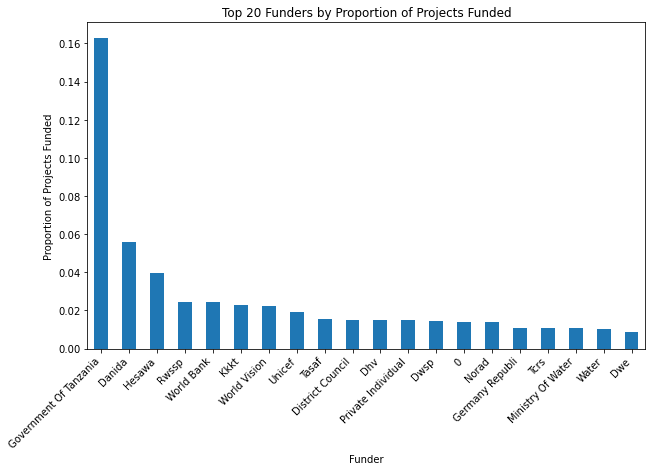

In [20]:
# Calculate value counts and then the proportions
funder_value_counts = df_train_merge['funder'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(10,6))  # Sets the size of the figure
funder_value_counts.head(20).plot(kind='bar')  # Display the top 20 funders for readability

# Set the title and labels
plt.title('Top 20 Funders by Proportion of Projects Funded')
plt.xlabel('Funder')
plt.ylabel('Proportion of Projects Funded')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [21]:
df_train_merge["funder"].value_counts(normalize=True)

Government Of Tanzania      0.162898
Danida                      0.055841
Hesawa                      0.039487
Rwssp                       0.024639
World Bank                  0.024191
                              ...   
Cida                        0.000018
M And P                     0.000018
Bingo Foundation Germany    0.000018
Rotery C                    0.000018
Irevea Sister Water         0.000018
Name: funder, Length: 1897, dtype: float64

In [22]:
# Looking at all the values in the funder column

# for valor in df_train_merge["funder"].unique():
#      print(valor)

In [23]:
# Handling NaN values with a filler string like 'Unknown'
df_train_merge['funder'] = df_train_merge['funder'].fillna('Unknown').astype(str)

# Apply the mapping function to the 'funder' column
df_train_merge['funder_type'] = df_train_merge['funder'].apply(categorize_funder)

# Check the categorized data
print(df_train_merge['funder_type'].value_counts())

Individual/Other           39410
Government                 10017
International Aid           8468
Religious Organizations     1299
NGO                          146
Private Companies             60
Name: funder_type, dtype: int64


For the time being, we will advance with this categorization and decide later if we want to further investigate the Individual/Other category if necessary

**Column 'installer'**

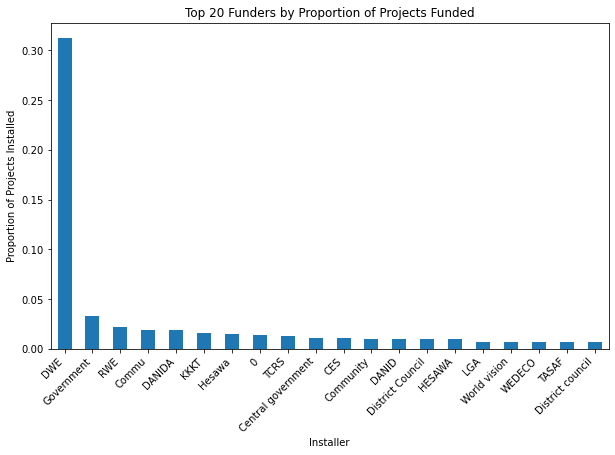

In [24]:
# Calculate value counts and then the proportions
funder_value_counts = df_train_merge['installer'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(10,6))  # Sets the size of the figure
funder_value_counts.head(20).plot(kind='bar')  # Display the top 20 funders for readability

# Set the title and labels
plt.title('Top 20 Funders by Proportion of Projects Funded')
plt.xlabel('Installer')
plt.ylabel('Proportion of Projects Installed')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [25]:
# Looking at all the values in the installer column

# for valor in df_train_merge["installer"].unique():
#     print(valor)

In [26]:
# Handling NaN values with a filler string like 'Unknown'
df_train_merge['installer'] = df_train_merge['installer'].fillna('Unknown').astype(str)

# Apply the mapping function to the 'installer' column
df_train_merge['installer_type'] = df_train_merge['installer'].apply(categorize_installer)

# Now you can check your categorized data
print(df_train_merge['installer_type'].value_counts())


Other              34031
DWE                18121
Government          3753
Community           2338
Institutional        701
NGO                  327
Private Company      129
Name: installer_type, dtype: int64


For the time being, we will advance with this categorization and decide later if we want to further investigate the Individual/Other category if necessary

**Column 'scheme_management'**

In [27]:
df_train_merge["scheme_management"].value_counts(normalize=True)

VWC                 0.662662
WUG                 0.093763
Water authority     0.056787
WUA                 0.051924
Water Board         0.049493
Parastatal          0.030258
Private operator    0.019145
Company             0.019109
Other               0.013796
SWC                 0.001747
Trust               0.001297
None                0.000018
Name: scheme_management, dtype: float64

We will categorize, based on this classification:

- Governmental Entities: Combine 'VWC' (Village Water Committee), 'Water authority', and 'Parastatal' into a single 'Government' category. These typically represent different layers or types of governmental involvement.

- Community Managed: Merge 'WUG' (Water User Group) and 'WUA' (Water User Association) into 'Community'. These are likely community-based management structures.

- Commercial Entities: Group 'Company' and 'Private operator' into 'Private Sector'. These likely represent privately managed schemes.

- Institutional Boards: Keep 'Water Board' as is if they represent formal institutional water management boards that don't fit into other categories.

- Other and Miscellaneous: Combine 'SWC', 'Trust', 'None', and 'Other' into 'Other'. These categories might represent less common or unclear management structures.

In [28]:
# Apply the grouping function to the 'scheme_management' column
df_train_merge['scheme_management_grouped'] = df_train_merge['scheme_management'].apply(group_scheme_management)

# Check the new value counts to see the grouped data
print(df_train_merge['scheme_management_grouped'].value_counts(normalize=True))


Government        0.700774
Community         0.136178
Other             0.081027
Water Board       0.046263
Private Sector    0.035758
Name: scheme_management_grouped, dtype: float64


**Column 'scheme_name'**

In [29]:
df_train_merge["scheme_name"].value_counts(normalize=True)

K                                  0.021835
None                               0.020619
Borehole                           0.017481
Chalinze wate                      0.012967
M                                  0.012807
                                     ...   
The Desk and chair fondation       0.000032
Nameqhuwadiba                      0.000032
Mulu                               0.000032
Njalamatatawater gravity scheme    0.000032
Kayugi spring source               0.000032
Name: scheme_name, Length: 2696, dtype: float64

Given that there is almost 50% of unknown data, and the widespread of data, we will eliminate this column directly

In [30]:
# Start creating our drop list
drop_column_list = ['scheme_name']

**Column 'num_private'**

In [31]:
df_train_merge['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

Given that num_private has no description and given that it has many values, we are going to add this to the drop list column

In [32]:
drop_column_list.append('num_private')
drop_column_list

['scheme_name', 'num_private']

**Column 'wpt_name '**

In [33]:
df_train_merge['wpt_name'].value_counts()

none                     3563
Shuleni                  1748
Zahanati                  830
Msikitini                 535
Kanisani                  323
                         ... 
Chienje                     1
Salum Langi                 1
Juhudi Primary School       1
Kiwalani                    1
Mugaya Maginga              1
Name: wpt_name, Length: 37400, dtype: int64

No further information is added with this wpt_name column as it is the name of the waterpoint. We will add this to the drop_list

In [34]:
drop_column_list.append('wpt_name')
drop_column_list

['scheme_name', 'num_private', 'wpt_name']

**Column 'construction_year'**

Converting 'construction_year' to object

In [35]:
df_train_merge['construction_year'] = df_train_merge['construction_year'].astype('object')
print(df_train_merge['construction_year'].dtype)

object


In [36]:
df_train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         59400 non-null  int64  
 1   amount_tsh                 59400 non-null  float64
 2   date_recorded              59400 non-null  object 
 3   funder                     59400 non-null  object 
 4   gps_height                 59400 non-null  int64  
 5   installer                  59400 non-null  object 
 6   longitude                  59400 non-null  float64
 7   latitude                   59400 non-null  float64
 8   wpt_name                   59400 non-null  object 
 9   num_private                59400 non-null  int64  
 10  basin                      59400 non-null  object 
 11  subvillage                 59029 non-null  object 
 12  region                     59400 non-null  object 
 13  region_code                59400 non-null  int

**Columns: 'subvillage' and 'region'**

In [37]:
df_train_merge['subvillage'].value_counts()

Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Kong'Olo         1
Rwamianya        1
Ujmaa A          1
Rwibitembe       1
Nyabilezi A      1
Name: subvillage, Length: 19287, dtype: int64

In [38]:
df_train_merge['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

Having subvillage wouldn't give more insights to the model. There are more than 19k registrations of subvillages. Column 'region' alredy is a categorization of column 'subvillage' and so, we decide to add this column to the drop_list

In [39]:
drop_column_list.append('subvillage')
drop_column_list

['scheme_name', 'num_private', 'wpt_name', 'subvillage']

**Columns: 'lga', 'ward'**

In [40]:
df_train_merge['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [41]:
df_train_merge['ward'].value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Igogo          1
Mlimani        1
Kapilula       1
Korongoni      1
Burungura      1
Name: ward, Length: 2092, dtype: int64

As we already have column 'region' and columns: 'lga' and 'ward' are geographic locations. To avoid multiollinearity we will add 'lga'and 'ward' to the drop_list

In [42]:
drop_column_list.append('lga')
drop_column_list.append('ward')

drop_column_list

['scheme_name', 'num_private', 'wpt_name', 'subvillage', 'lga', 'ward']

**Columns: 'recorded_by'**

In [43]:
df_train_merge['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [44]:
# Drop recorded_by column since it's constant and should be ignored
drop_column_list.append('recorded_by')
drop_column_list

['scheme_name',
 'num_private',
 'wpt_name',
 'subvillage',
 'lga',
 'ward',
 'recorded_by']

**Dropping the columns list**

In [45]:
# Carry out the dropping
df_train_merge = df_train_merge.drop(drop_column_list, axis=1)

In [46]:
df_train_merge.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'population', 'public_meeting', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'funder_type', 'installer_type',
       'scheme_management_grouped'],
      dtype='object')

##### 3.5.1.3.2 - Transforming column types

In [47]:
df_train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         59400 non-null  int64  
 1   amount_tsh                 59400 non-null  float64
 2   date_recorded              59400 non-null  object 
 3   funder                     59400 non-null  object 
 4   gps_height                 59400 non-null  int64  
 5   installer                  59400 non-null  object 
 6   longitude                  59400 non-null  float64
 7   latitude                   59400 non-null  float64
 8   basin                      59400 non-null  object 
 9   region                     59400 non-null  object 
 10  region_code                59400 non-null  int64  
 11  district_code              59400 non-null  int64  
 12  population                 59400 non-null  int64  
 13  public_meeting             56066 non-null  obj

**Column 'date_recorded'**

In [48]:
df_train_merge['date_recorded']

0        2011-03-14
1        2013-03-06
2        2013-02-25
3        2013-01-28
4        2011-07-13
            ...    
59395    2013-05-03
59396    2011-05-07
59397    2011-04-11
59398    2011-03-08
59399    2011-03-23
Name: date_recorded, Length: 59400, dtype: object

In [49]:
df_train_merge['date_recorded'] = pd.to_datetime(df_train_merge['date_recorded'])

print(df_train_merge['date_recorded'].dtype)

datetime64[ns]


As can be seen, the date_recorded column has to be converted to date type

**Column 'public_meeting'**

In [50]:
print(df_train_merge['public_meeting'].dtype)

object


**Column 'permit'**

In [51]:
print(df_train_merge['permit'].dtype)

object


##### 3.5.1.3.3 - Cleaning the dataset

In [52]:
# Apply the cleaning function to each object-type column in the DataFrame
for col in df_train_merge.select_dtypes(include='object').columns:
    df_train_merge[col] = df_train_merge[col].apply(clean_text)

# Display the cleaned DataFrame
df_train_merge.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,funder_type,installer_type,scheme_management_grouped
0,69572,6000.0,2011-03-14,roman,1390,roman,34.938093,-9.856322,lake nyasa,iringa,...,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,individualother,other,government
1,8776,0.0,2013-03-06,grumeti,1399,grumeti,34.698766,-2.147466,lake victoria,mara,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,individualother,other,other
2,34310,25.0,2013-02-25,lottery club,686,world vision,37.460664,-3.821329,pangani,manyara,...,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,individualother,other,government
3,67743,0.0,2013-01-28,unicef,263,unicef,38.486161,-11.155298,ruvuma southern coast,mtwara,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,international aid,ngo,government
4,19728,0.0,2011-07-13,action in a,0,artisan,31.130847,-1.825359,lake victoria,kagera,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,individualother,other,other


### 3.5.2 Descriptive Analysis

#### 3.5.2.1 Univaried Analysis

**Numerical columns**

In [53]:
numeric_columns = df_train_merge.select_dtypes(include=[np.number])

# Let's exclude certain columns of numerical columns
numeric_columns

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
0,69572,6000.0,1390,34.938093,-9.856322,11,5,109,1999
1,8776,0.0,1399,34.698766,-2.147466,20,2,280,2010
2,34310,25.0,686,37.460664,-3.821329,21,4,250,2009
3,67743,0.0,263,38.486161,-11.155298,90,63,58,1986
4,19728,0.0,0,31.130847,-1.825359,18,1,0,0
...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,1210,37.169807,-3.253847,3,5,125,1999
59396,27263,4700.0,1212,35.249991,-9.070629,11,4,56,1996
59397,37057,0.0,0,34.017087,-8.750434,12,7,0,0
59398,31282,0.0,0,35.861315,-6.378573,1,4,0,0


In [54]:
numeric_columns = numeric_columns.drop(['id','longitude','latitude','region_code','district_code','construction_year'], axis=1)

In [55]:
numeric_columns

,amount_tsh,gps_height,population
0,6000.0,1390,109
1,0.0,1399,280
2,25.0,686,250
3,0.0,263,58
4,0.0,0,0
...,...,...,...
59395,10.0,1210,125
59396,4700.0,1212,56
59397,0.0,0,0
59398,0.0,0,0


Stats for amount_tsh:
Max: 350000.0
Min: 0.0
Mean: 317.6503846801347
Median: 0.0
Standard Deviation: 2997.574558142169
Coefficient of Variation: 9.436709989067523
Skewness: 57.8077999458852
Kurtosis: 4903.543101955053
25th percentile (Q1): 0.0
50th percentile (Median): 0.0
75th percentile (Q3): 20.0


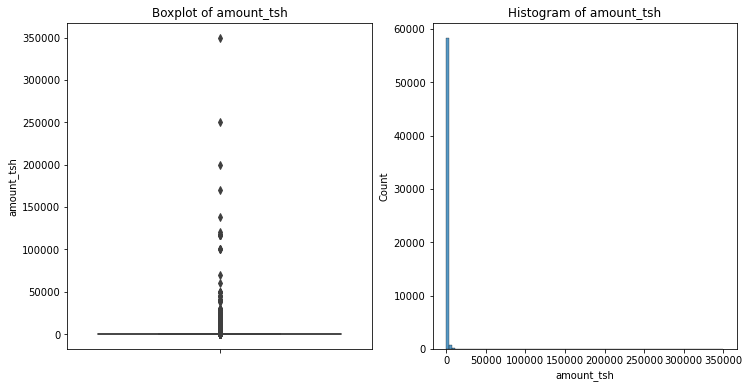

Stats for gps_height:
Max: 2770
Min: -90
Mean: 668.297239057239
Median: 369.0
Standard Deviation: 693.11635032505
Coefficient of Variation: 1.037137833013979
Skewness: 0.4624020849809572
Kurtosis: -1.2924401348688863
25th percentile (Q1): 0.0
50th percentile (Median): 369.0
75th percentile (Q3): 1319.25


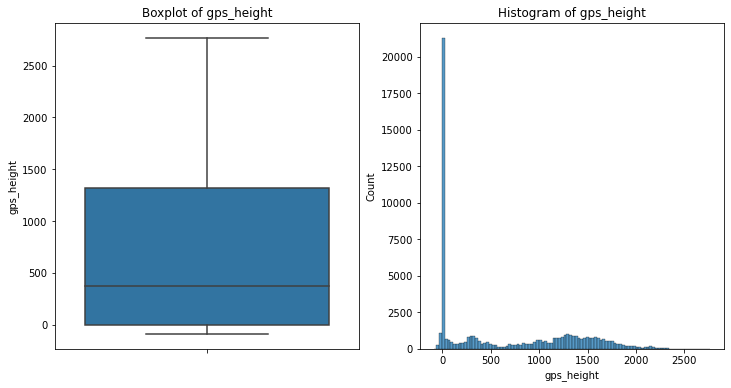

Stats for population:
Max: 30500
Min: 0
Mean: 179.90998316498317
Median: 25.0
Standard Deviation: 471.48217573848035
Coefficient of Variation: 2.620655993870647
Skewness: 12.660713588843592
Kurtosis: 402.28011526096975
25th percentile (Q1): 0.0
50th percentile (Median): 25.0
75th percentile (Q3): 215.0


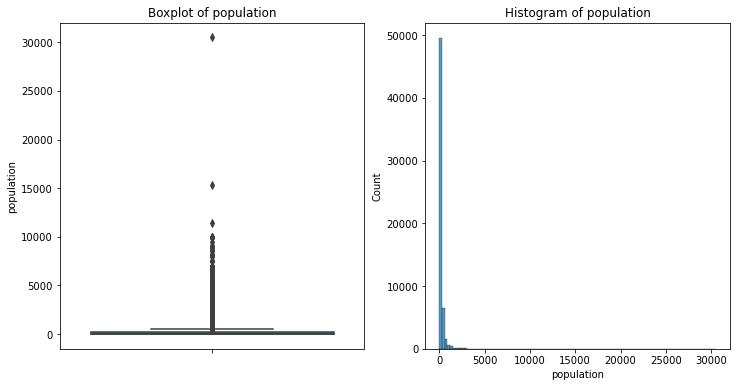

In [56]:
# Now let's analyze these numeric columns

analyze_numeric_stats_and_plots(df_train_merge, numeric_columns)

**Categorical columns**

In [57]:
categorical_columns = df_train_merge.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['funder', 'installer', 'basin', 'region', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'funder_type', 'installer_type',
       'scheme_management_grouped'],
      dtype='object')

In [58]:
categorical_columns = categorical_columns.drop(['funder','installer','scheme_management','status_group'])

In [59]:
## Plot the distributions

#plot_categorical_proportions(df_train_merge, categorical_columns)


Here are the observations from the categorical columns:

- extraction_type_group and extraction_type are already classified in extraction_type_group_class so we will use the latter group

- we see that in management, VWC contains most of the data. management_group is then a grouping of all the data and thus has fewer categories. So we will use management_group instead of the management column

- columns: payment and payment_type have the same categories and distributions. We will thus keep one only. We chose payment_type. 

- we see that in water_quality, soft contains most of the data. quality_group is then a grouping of all the data and thus has fewer categories. So we will use quality_group instead of the water_quality column

- columns: quantity and quantity_group have the same categories and distributions. We will thus keep one only. We chose quantity_group.

- looking at the column source we see different categories and then when looking at source_type we can see that it has joined certain groups from the source column successfully. We consider source_type to have a better description of the data. Moreover, we will disregard source_class because we consider that source_type will give us interesting insights to the data. If in the future we see that the model is not convincing with the number of categories from source_type, we will use source_class

- We will keep waterpoint_type_group over waterpoint_type because we consider it beneficial to have grouped communal standpipe and communal standpipe multiple together.

In [60]:
drop_categorical_columns = ['extraction_type_group', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'source_class','waterpoint_type_group']

In [61]:
# Drop the list of columns from df_train_merge
df_train_merge = df_train_merge.drop(drop_categorical_columns, axis=1)

#### 3.5.1.5 Multivaried Analysis

In [62]:
numeric_columns.columns

Index(['amount_tsh', 'gps_height', 'population'], dtype='object')

In [63]:
categorical_columns = categorical_columns.drop(drop_categorical_columns)
drop_categorical_columns

['extraction_type_group',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type_group']

In [64]:
# Let's join together numeric_columns and categorical_columns into a list that we will pass as an argument to the multavaried
# analysis function

combined_columns = numeric_columns.columns.tolist() + categorical_columns.tolist()
combined_columns

['amount_tsh',
 'gps_height',
 'population',
 'basin',
 'region',
 'public_meeting',
 'permit',
 'extraction_type_class',
 'management_group',
 'payment_type',
 'quality_group',
 'quantity_group',
 'source_type',
 'waterpoint_type',
 'funder_type',
 'installer_type',
 'scheme_management_grouped']

In [65]:
df_train_merge.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'population', 'public_meeting', 'scheme_management',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'waterpoint_type', 'status_group', 'funder_type',
       'installer_type', 'scheme_management_grouped'],
      dtype='object')

In order to see the distribution of variables with respect to the objective function. We decide to group the status group column and join functional and functional needs repair. In this way we make a binary classification of the status group column. 

In [66]:
# Replace 'functional needs repair' with 'functional'
df_train_merge['status_group_1'] = df_train_merge['status_group'].replace('functional needs repair', 'functional')

# Verify changes by checking the class distribution again in y_train and y_test
print("Class distribution in y_train after replacement:")
print(df_train_merge['status_group_1'].value_counts(normalize=True))

Class distribution in y_train after replacement:
functional        0.615758
non functional    0.384242
Name: status_group_1, dtype: float64


In [67]:
## Apply the function for multivaried analysis

#plot_grouped_charts(df_train_merge, 'status_group_1', combined_columns)


**Contingency Tables**

In [68]:
categorical_columns

Index(['basin', 'region', 'public_meeting', 'permit', 'extraction_type_class',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'waterpoint_type', 'funder_type', 'installer_type',
       'scheme_management_grouped'],
      dtype='object')

In [69]:
tables = generate_proportion_contingency_tables(df_train_merge, 'status_group_1', categorical_columns)

In [70]:
for i in categorical_columns:
    print(f"Table for {i}:")
    
    # Convert the values to percentages with the percentage symbol
    table = tables[i].applymap(lambda x: f"{x:.2f}%")
    
    display(table)
    print("\n")  # Adds a newline for better separation


Table for basin:


basin,internal,lake nyasa,lake rukwa,lake tanganyika,lake victoria,pangani,rufiji,ruvuma southern coast,wami ruvu
status_group_1,,,,,,,,,
functional,13.78%,9.77%,3.47%,10.52%,16.65%,15.99%,15.05%,5.46%,9.31%
non functional,12.03%,6.62%,5.19%,11.32%,18.22%,13.54%,10.83%,10.94%,11.31%




Table for region:


region,arusha,dar es salaam,dodoma,iringa,kagera,kigoma,kilimanjaro,lindi,manyara,mara,...,morogoro,mtwara,mwanza,pwani,rukwa,ruvuma,shinyanga,singida,tabora,tanga
status_group_1,,,,,,,,,,,,,,,,,,,,,
functional,6.75%,1.27%,3.33%,11.66%,5.55%,5.38%,8.10%,1.51%,2.96%,2.59%,...,6.61%,1.78%,4.61%,4.35%,2.30%,4.49%,9.36%,3.11%,2.44%,4.13%
non functional,3.86%,1.49%,4.31%,4.51%,5.63%,3.72%,6.21%,4.35%,2.19%,4.48%,...,6.95%,4.73%,6.21%,4.57%,4.23%,4.36%,6.83%,4.18%,4.67%,4.55%




Table for public_meeting:


public_meeting,False,True
status_group_1,,
functional,7.53%,92.47%
non functional,11.44%,88.56%




Table for permit:


permit,False,True
status_group_1,,
functional,29.95%,70.05%
non functional,32.78%,67.22%




Table for extraction_type_class:


extraction_type_class,gravity,handpump,motorpump,other,rope pump,submersible,windpowered
status_group_1,,,,,,,
functional,51.26%,31.09%,3.48%,3.38%,0.85%,9.79%,0.16%
non functional,35.19%,22.28%,7.51%,22.76%,0.62%,11.38%,0.26%




Table for management_group:


management_group,commercial,other,parastatal,unknown,usergroup
status_group_1,,,,,
functional,6.43%,1.60%,3.37%,0.69%,87.92%
non functional,5.63%,1.57%,2.35%,1.36%,89.08%




Table for payment_type:


payment_type,annually,monthly,never pay,on failure,other,per bucket,unknown
status_group_1,,,,,,,
functional,8.17%,17.52%,36.32%,7.40%,1.99%,17.77%,10.83%
non functional,2.87%,8.29%,52.85%,5.29%,1.42%,10.89%,18.39%




Table for quality_group:


quality_group,colored,fluoride,good,milky,salty,unknown
status_group_1,,,,,,
functional,0.82%,0.46%,89.30%,1.24%,7.36%,0.82%
non functional,0.83%,0.21%,79.54%,1.54%,10.97%,6.91%




Table for quantity_group:


quantity_group,dry,enough,insufficient,seasonal,unknown
status_group_1,,,,,
functional,0.53%,65.75%,25.61%,7.49%,0.62%
non functional,26.52%,40.04%,25.25%,5.74%,2.46%




Table for source_type:


source_type,borehole,dam,other,rainwater harvesting,riverlake,shallow well,spring
status_group_1,,,,,,,
functional,17.57%,0.76%,0.45%,4.65%,18.76%,25.37%,32.45%
non functional,24.19%,1.66%,0.50%,2.61%,15.41%,33.05%,22.58%




Table for waterpoint_type:


waterpoint_type,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
status_group_1,,,,,,,
functional,0.24%,54.64%,7.88%,0.02%,32.35%,1.77%,3.10%
non functional,0.13%,37.40%,14.11%,0.00%,24.77%,0.60%,22.99%




Table for funder_type:


funder_type,government,individualother,international aid,ngo,private companies,religious organizations
status_group_1,,,,,,
functional,13.19%,69.10%,14.50%,0.22%,0.12%,2.87%
non functional,22.75%,61.93%,13.87%,0.29%,0.07%,1.10%




Table for installer_type:


installer_type,community,dwe,government,institutional,ngo,other,private company
status_group_1,,,,,,,
functional,4.62%,31.35%,4.40%,1.55%,0.50%,57.36%,0.22%
non functional,2.85%,29.16%,9.40%,0.58%,0.63%,57.18%,0.21%




Table for scheme_management_grouped:


scheme_management_grouped,community,government,other,private sector,water board
status_group_1,,,,,
functional,16.16%,67.06%,7.24%,3.62%,5.92%
non functional,9.54%,74.91%,9.48%,3.51%,2.56%


From the study above, we can have an insight of which variables are going to be determinant when running the classification model. These variables are: region, extraction_type_class, payment_type, quantity_group, waterpoint_type, scheme_management_grouped

# 4. Exporting the data

In [71]:
combined_columns.append('status_group')

In [72]:
df_train_merge[combined_columns].to_excel('df_train_transform.xlsx', index=False)